# Data splitters

Splitting your data in a Machine Learning pipeline is a crucial step. It is important to make sure that the data is split in a way that the model is not overfitting. In this tutorial we will show you how to use the splitters in DeepMol. Some splitters allow us to have an easier task for a model to learn, while others allow us to have a more difficult task for a model to learn. We will show you how to use the splitters and how to use them in a pipeline.

## Import data

In [7]:
from deepmol.splitters import SingletaskStratifiedSplitter
from deepmol.loaders import CSVLoader
from deepmol.splitters import SimilaritySplitter

from deepmol.compound_featurization import MorganFingerprint

from deepmol.models import SklearnModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from deepmol.metrics import Metric
import pandas as pd

### Create function to generate t-SNE embeddings

In [8]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def generate_tsne_molecular_similarities(train_dataset, valid_dataset, test_dataset):
    # Create a function to compute molecular fingerprints
    def compute_fingerprint(smiles):
        molecule = Chem.MolFromSmiles(smiles)
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024)
        return fingerprint

    # Compute molecular fingerprints for each molecule in the combined dataset
    fingerprints = [compute_fingerprint(smiles) for smiles in train_dataset.smiles]
    fingerprints.extend([compute_fingerprint(smiles) for smiles in valid_dataset.smiles])
    fingerprints.extend([compute_fingerprint(smiles) for smiles in test_dataset.smiles])

    similarity_matrix = np.zeros((len(fingerprints), len(fingerprints)))
    # Compute molecular similarities using Tanimoto coefficient
    for i in range(len(fingerprints)):
        for j in range(i + 1, len(fingerprints)):
            similarity = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

    # Apply t-SNE to reduce the dimensionality
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(similarity_matrix)
    # Separate the embeddings based on the original datasets
    dataset1_embeddings = tsne_embeddings[:len(train_dataset.smiles)]
    dataset2_embeddings = tsne_embeddings[len(train_dataset.smiles):len(valid_dataset.smiles) + len(train_dataset.smiles)]
    dataset3_embeddings = tsne_embeddings[len(valid_dataset.smiles) + len(train_dataset.smiles):]

    # increase the size of the plot
    plt.figure(figsize=(10, 10))

    # Plot the embeddings with different colors for each dataset
    plt.scatter(dataset1_embeddings[:, 0], dataset1_embeddings[:, 1], c='red', label='Train dataset', s=[2]*len(dataset1_embeddings))
    plt.scatter(dataset2_embeddings[:, 0], dataset2_embeddings[:, 1], c='blue', label='Validation dataset', s=[2]*len(dataset2_embeddings))
    plt.scatter(dataset3_embeddings[:, 0], dataset3_embeddings[:, 1], c='green', label='Test dataset', s=[2]*len(dataset3_embeddings))
    plt.legend()
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('Molecular Similarities with t-SNE')
    plt.show()

In [9]:
dataset = CSVLoader("dataset_last_version2.csv", 
                    smiles_field="Smiles", labels_fields=["Class"]).create_dataset(sep=";")

[22:05:32] SMILES Parse Error: syntax error while parsing: COc1ccc(CCc2ccccc2CO)cc1O09y78
[22:05:32] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(CCc2ccccc2CO)cc1O09y78' for input: 'COc1ccc(CCc2ccccc2CO)cc1O09y78'
[22:05:32] Explicit valence for atom # 8 N, 4, is greater than permitted
[22:05:32] Explicit valence for atom # 4 N, 4, is greater than permitted
[22:05:32] Explicit valence for atom # 3 N, 4, is greater than permitted
[22:05:32] Explicit valence for atom # 11 O, 3, is greater than permitted
[22:05:32] SMILES Parse Error: syntax error while parsing: CN[C@H](CC(C)C)C(=O)N[C@@H]1[C@H](O)c2ccc(Oc3cc4cc(Oc5ccc(cc5Cl)[C@@H](O)[C@@H]6NC(=O)[C@H](NC(=O)[C@@H]4NC(=O)[C@H](CC(=O)N)NC1=O)c7ccc(O)c(c7)c8c(O)cc(O)cc8[C@H](NC6=O)C(=O)O)c3O[C@@H]9O[C@H](CO)[C@@H](O)[C@H](O)[C@H]9O[C@H]%10C[C@](C)(N)[C@H](O)[C
[22:05:32] SMILES Parse Error: Failed parsing SMILES 'CN[C@H](CC(C)C)C(=O)N[C@@H]1[C@H](O)c2ccc(Oc3cc4cc(Oc5ccc(cc5Cl)[C@@H](O)[C@@H]6NC(=O)[C@H](NC(=O)[C@@H]4NC(=O)[C@H](CC(=O)

2025-01-17 22:05:32,990 — INFO — Assuming classification since there are less than 10 unique y values. If otherwise, explicitly set the mode to 'regression'!


[22:05:32] WARNING: not removing hydrogen atom without neighbors
[22:05:32] WARNING: not removing hydrogen atom without neighbors


# Splitters

## SingletaskStratifiedSplitter

A single task stratified splitter splits the data into train, validation and test sets. The data is split in a way that the distribution of the labels is the same in each set. This is useful when we have a dataset with a large number of classes and we want to make sure that the distribution of the classes is the same in each set.

In [10]:
splitter = SingletaskStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1)

### Below we can see the distribution of the labels in each set

As you might see, the distribution of the labels is roughly the same in each set.

In [11]:
train_dataset.get_shape()

2025-01-17 22:05:43,388 — INFO — Mols_shape: (1860,)
2025-01-17 22:05:43,390 — INFO — Features_shape: None
2025-01-17 22:05:43,390 — INFO — Labels_shape: (1860,)


((1860,), None, (1860,))

In [38]:
pd.Series(train_dataset.y).value_counts()

0    6658
1    6657
dtype: int64

In [7]:
valid_dataset.get_shape()

2023-05-30 19:26:07,727 — INFO — Mols_shape: (1664,)
2023-05-30 19:26:07,728 — INFO — Features_shape: None
2023-05-30 19:26:07,729 — INFO — Labels_shape: (1664,)


((1664,), None, (1664,))

In [39]:
pd.Series(valid_dataset.y).value_counts()

1    849
0    832
dtype: int64

In [8]:
test_dataset.get_shape()

2023-05-30 19:26:10,047 — INFO — Mols_shape: (1665,)
2023-05-30 19:26:10,049 — INFO — Features_shape: None
2023-05-30 19:26:10,050 — INFO — Labels_shape: (1665,)


((1665,), None, (1665,))

In [40]:
pd.Series(test_dataset.y).value_counts()

0    833
1    816
dtype: int64

### Below we can see the distribution of the molecules in each set

/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


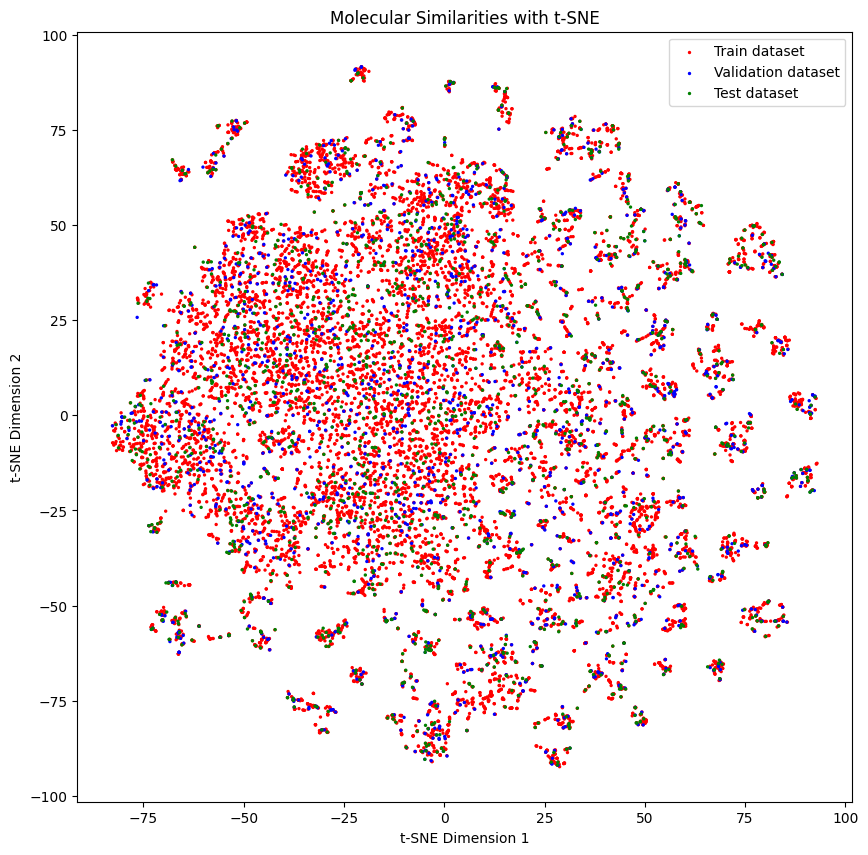

In [9]:
generate_tsne_molecular_similarities(train_dataset, valid_dataset, test_dataset)

## MultiTaskSplitter

In [71]:
from deepmol.splitters import MultiTaskStratifiedSplitter

dataset = CSVLoader("../data/tox21.csv", id_field="mol_id",
                    smiles_field="smiles", labels_fields=["NR-AR","NR-AR-LBD","NR-AhR",
                                                          "NR-Aromatase", "NR-ER", "NR-ER-LBD",
                                                          "NR-PPAR-gamma", "SR-ARE","SR-ATAD5","SR-HSE","SR-MMP","SR-p53"]).create_dataset()

[18:35:38] WARNING: not removing hydrogen atom without neighbors


2023-06-27 18:35:39,339 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


In [72]:
train_dataset, test_dataset = MultiTaskStratifiedSplitter().train_test_split(dataset, frac_train=0.8)

In [73]:
import numpy as np

num_ones_per_column_train_dataset = np.sum(train_dataset.y == 1, axis=0)
num_ones_per_column_test_dataset = np.sum(test_dataset.y == 1, axis=0)
total = num_ones_per_column_train_dataset + num_ones_per_column_test_dataset

print("The percentage of each task label in the training set is:", num_ones_per_column_train_dataset / total)
print("The average percentage of the tasks labels in the training set is :", np.mean(num_ones_per_column_train_dataset / total))
print()
print("The percentage of each task label in the test set is:", num_ones_per_column_test_dataset / total)
print("The average percentage of the tasks labels in the test set is :", np.mean(num_ones_per_column_test_dataset / total))

The percentage of each task label in the training set is: [0.77669903 0.79746835 0.79427083 0.78333333 0.80075662 0.80857143
 0.8172043  0.79087049 0.74242424 0.7983871  0.82244009 0.79196217]
The average percentage of the tasks labels in the training set is : 0.7936989991588942

The percentage of each task label in the test set is: [0.22330097 0.20253165 0.20572917 0.21666667 0.19924338 0.19142857
 0.1827957  0.20912951 0.25757576 0.2016129  0.17755991 0.20803783]
The average percentage of the tasks labels in the test set is : 0.20630100084110578


In [74]:
from deepmol.splitters import RandomSplitter
train_dataset, test_dataset = RandomSplitter().train_test_split(dataset, frac_train=0.8)

In [75]:
num_ones_per_column_train_dataset = np.sum(train_dataset.y == 1, axis=0)
num_ones_per_column_test_dataset = np.sum(test_dataset.y == 1, axis=0)
total = num_ones_per_column_train_dataset + num_ones_per_column_test_dataset

print("The percentage of each task label in the training set is:", num_ones_per_column_train_dataset / total)
print("The average percentage of the tasks labels in the training set is :", np.mean(num_ones_per_column_train_dataset / total))
print()
print("The percentage of each task label in the test set is:", num_ones_per_column_test_dataset / total)
print("The average percentage of the tasks labels in the test set is :", np.mean(num_ones_per_column_test_dataset / total))

The percentage of each task label in the training set is: [0.82200647 0.82700422 0.80729167 0.82333333 0.80075662 0.85142857
 0.82795699 0.80785563 0.83712121 0.7983871  0.81045752 0.8108747 ]
The average percentage of the tasks labels in the training set is : 0.818706169088316

The percentage of each task label in the test set is: [0.17799353 0.17299578 0.19270833 0.17666667 0.19924338 0.14857143
 0.17204301 0.19214437 0.16287879 0.2016129  0.18954248 0.1891253 ]
The average percentage of the tasks labels in the test set is : 0.18129383091168402


Then you can train them with a model. Here we use a random forest classifier.

In [11]:
MorganFingerprint().featurize(train_dataset, inplace=True)
MorganFingerprint().featurize(valid_dataset, inplace=True)
MorganFingerprint().featurize(test_dataset, inplace=True)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)

RandomForestClassifier()

In [12]:
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.9843843843843844}, {})

In [41]:
model.evaluate(valid_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.9898869720404521}, {})

## RandomSplitter

In [42]:
from deepmol.splitters import RandomSplitter

train_dataset, valid_dataset, test_dataset = RandomSplitter().train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1)

## Similarity Splitter

A similarity splitter splits the data into train, validation and test sets. The data is split in a way that the similarity between the molecules in each set is below a certain threshold. This is useful when we want to make sure that the molecules in the validation and test sets are either not too similar or similar to the molecules in the training set.

This splitter considers all the compounds with a similarity lower than the **homogenous_threshold** to be separated in the training set and test set. The higher the threshold is, the more heterogeneous the split will be.

Moreover, this method tries to ensure the stratification of classes.

In [12]:
from deepmol.splitters import GraphPartSimilaritySplitter

similarity_splitter = GraphPartSimilaritySplitter()

train_dataset, valid_dataset, test_dataset = similarity_splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1)

[22:05:56] WARNING: not removing hydrogen atom without neighbors
[22:05:56] WARNING: not removing hydrogen atom without neighbors
[22:05:56] WARNING: not removing hydrogen atom without neighbors
[22:05:56] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 2325/2325 [00:00<00:00, 3130.15it/s]


Full graph nr. of edges: 67668
232 [232]
Initialization mode slow-nn


Initializing: 2325it [00:00, 447533.58it/s]


Edge iteration completed in 0.04 seconds.
Edge sorting competed at 0.04 seconds.


clustering: 100%|██████████| 67668/67668 [00:00<00:00, 235746.50it/s]


1
Currently have this many samples: 2325
!  seq_3 seq_389 {'metric': 0.6521739130434783}  !
Need to remove! Currently have this many samples: 2325
After removal we have this many samples: 2297


### Below we can see the distribution of the labels in each set

In [13]:
pd.Series(train_dataset.y).value_counts()

1    1075
0     916
Name: count, dtype: int64

In [14]:
pd.Series(valid_dataset.y).value_counts()

0    91
1    56
Name: count, dtype: int64

In [15]:
pd.Series(test_dataset.y).value_counts()

0    98
1    61
Name: count, dtype: int64

### Below we can see the distribution of the molecules in each set - they look quite separated from each other

[22:06:12] WARNING: not removing hydrogen atom without neighbors
[22:06:12] WARNING: not removing hydrogen atom without neighbors
[22:06:12] WARNING: not removing hydrogen atom without neighbors
[22:06:12] WARNING: not removing hydrogen atom without neighbors


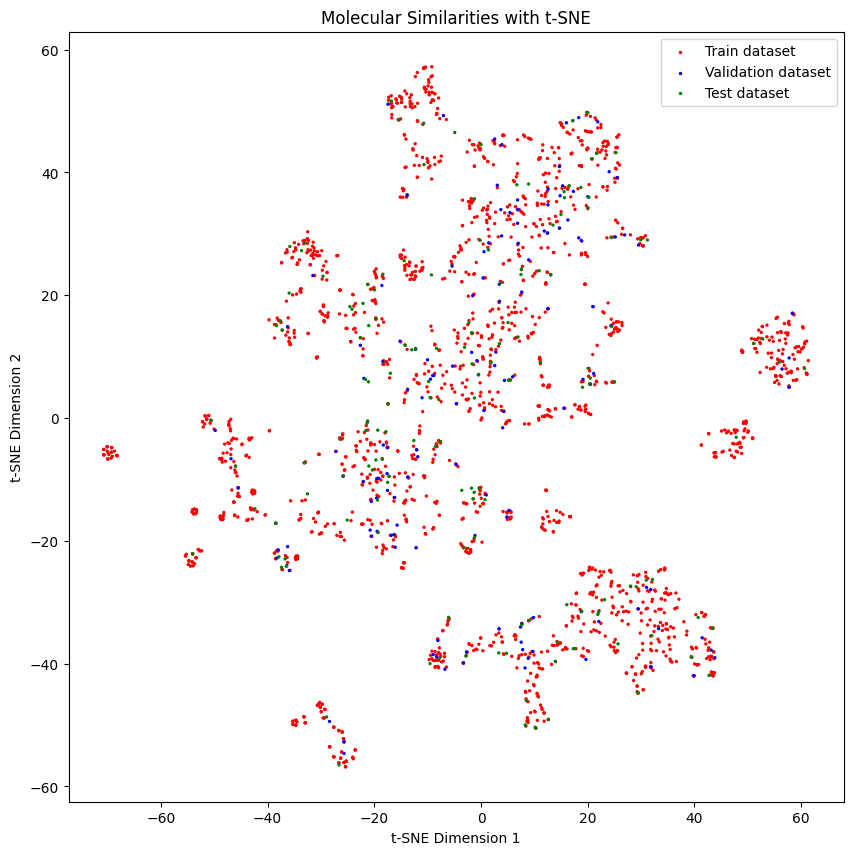

In [16]:
generate_tsne_molecular_similarities(train_dataset, valid_dataset, test_dataset)

Then you can train them with a model. Here we use a random forest classifier. The performance is not as good as with the stratified splitter, but it is still quite good.

In [17]:
MorganFingerprint().featurize(train_dataset, inplace=True)
MorganFingerprint().featurize(valid_dataset, inplace=True)
MorganFingerprint().featurize(test_dataset, inplace=True)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.7899159663865546}, {})

### Let's try with a lower threshold and see what happens

In [18]:
train_dataset, valid_dataset, test_dataset = similarity_splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, homogenous_threshold=0.10)

/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


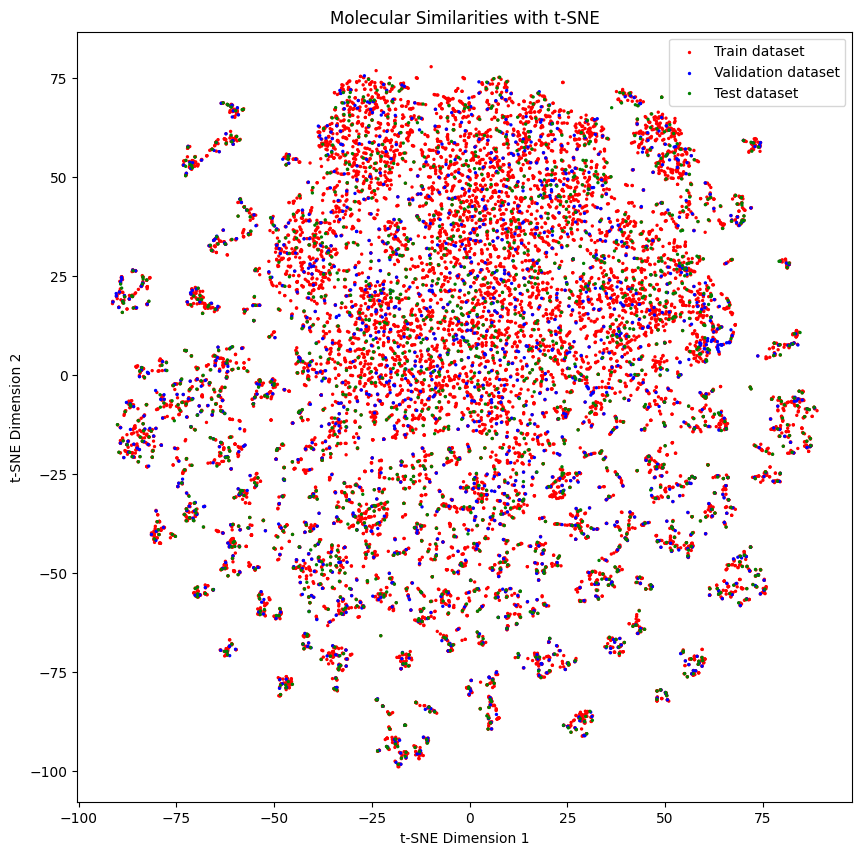

In [19]:
generate_tsne_molecular_similarities(train_dataset, valid_dataset, test_dataset)

Molecules don't look as separated as before, and of course, the performance is better than before.

In [21]:
MorganFingerprint().featurize(train_dataset, inplace=True)
MorganFingerprint().featurize(valid_dataset, inplace=True)
MorganFingerprint().featurize(test_dataset, inplace=True)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.9873949579831933}, {})

## Scaffold Splitter

The scaffold splitter splits the data into train, validation and test sets. The data is split in a way that the scaffolds of the molecules in each set are different or the same, depending on the **homogenous_datasets** parameter. This is useful when we want to make sure that the molecules in the validation and test sets are different or similar in terms of substructures from the molecules in the training set.

### Let's see how it works and create a split with different scaffolds in each set

In [49]:
from deepmol.splitters import ScaffoldSplitter

scaffold_splitter = ScaffoldSplitter()

train_dataset, valid_dataset, test_dataset = scaffold_splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, homogenous_datasets = False)

### Below we can see the distribution of the molecules in each set

As you might see, the distribution of the molecules in each set is a bit different.

/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


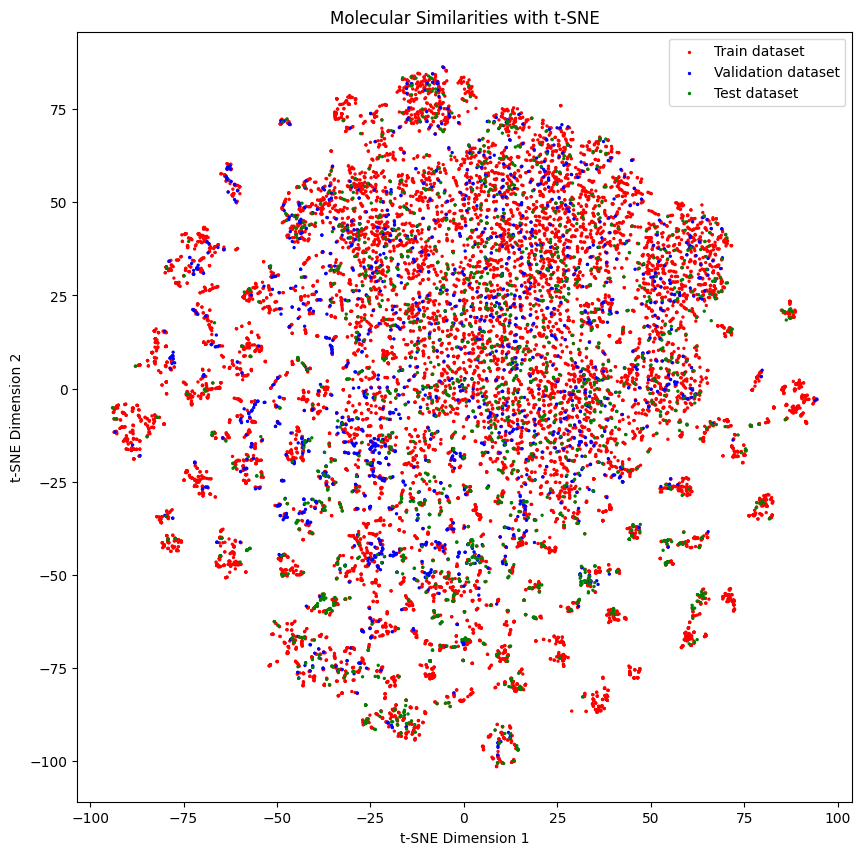

In [50]:
generate_tsne_molecular_similarities(train_dataset, valid_dataset, test_dataset)

### Let's see how it works when training a model

In [51]:
MorganFingerprint().featurize(train_dataset, inplace=True)
MorganFingerprint().featurize(valid_dataset, inplace=True)
MorganFingerprint().featurize(test_dataset, inplace=True)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.9663865546218487}, {})

### Let's make things a bit easier and create a split with similar scaffolds in each set

In [52]:
train_dataset, valid_dataset, test_dataset = scaffold_splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, homogenous_datasets = True)

/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


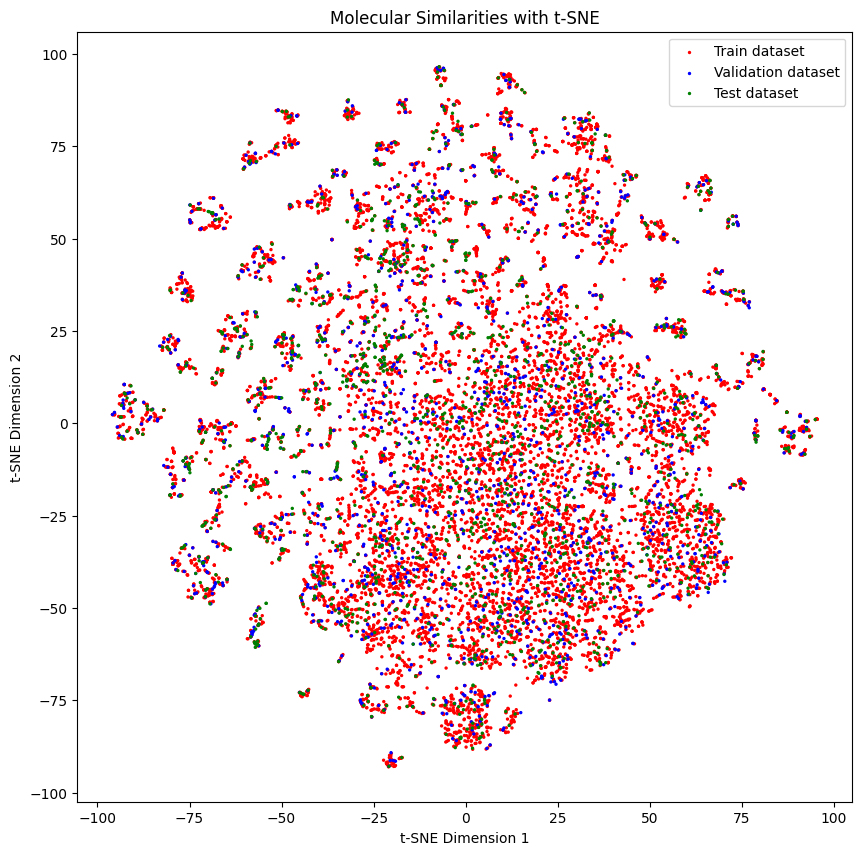

In [29]:
generate_tsne_molecular_similarities(train_dataset, valid_dataset, test_dataset)

In [53]:
MorganFingerprint().featurize(train_dataset, inplace=True)
MorganFingerprint().featurize(valid_dataset, inplace=True)
MorganFingerprint().featurize(test_dataset, inplace=True)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.9807923169267707}, {})

As you see, the performance is a bit better than before.

## Butina splitter

The Butina splitter splits the data into train, validation and test sets. The data is split in a way that the molecules in each set are different or similar according to a clustering method called Butina, depending on the **homogenous_datasets** parameter. This is useful when we want to make sure that the molecules in the validation and test sets are different or similar from the molecules in the training set.

In [54]:
from deepmol.splitters import ButinaSplitter

butina_splitter = ButinaSplitter()

train_dataset, valid_dataset, test_dataset = butina_splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, homogenous_datasets = False)

### Below we can see the distribution of the molecules in each set

As you might see, the distribution of the molecules in each set is a bit different.

/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


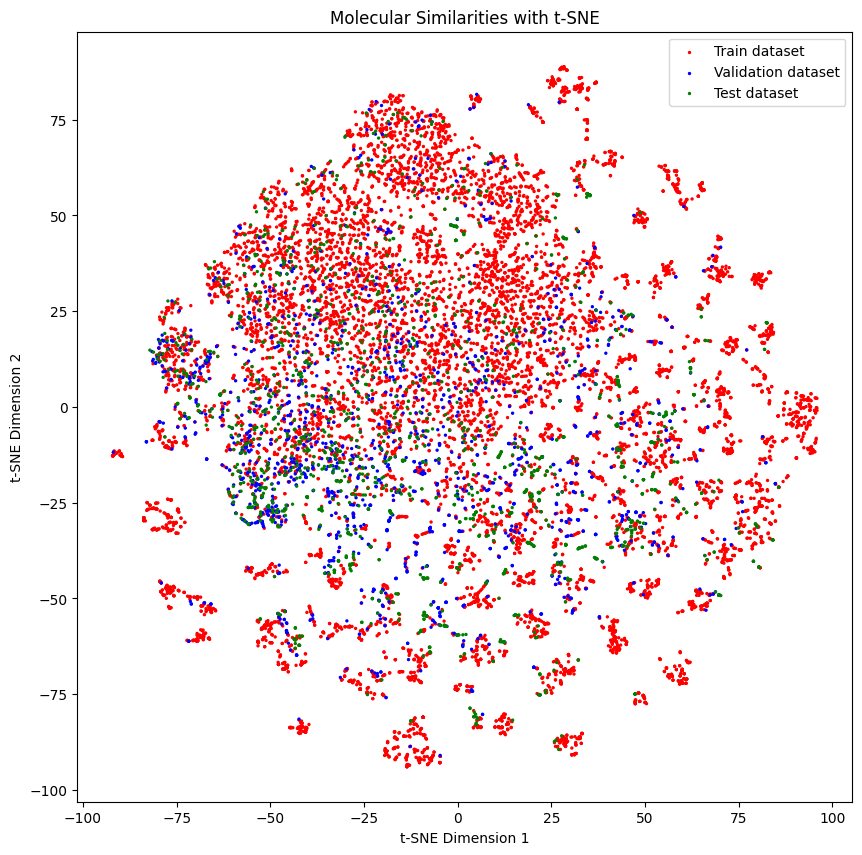

In [32]:
generate_tsne_molecular_similarities(train_dataset, valid_dataset, test_dataset)

In [55]:
MorganFingerprint().featurize(train_dataset, inplace=True)
MorganFingerprint().featurize(valid_dataset, inplace=True)
MorganFingerprint().featurize(test_dataset, inplace=True)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.9147659063625451}, {})

### Let's make things a bit easier and create a split with similar molecules in each set

In [34]:
butina_splitter = ButinaSplitter()

train_dataset, valid_dataset, test_dataset = butina_splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, homogenous_datasets = True)

### Below we can see the distribution of the molecules in each set

/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/joao/miniconda3/envs/deepmol/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


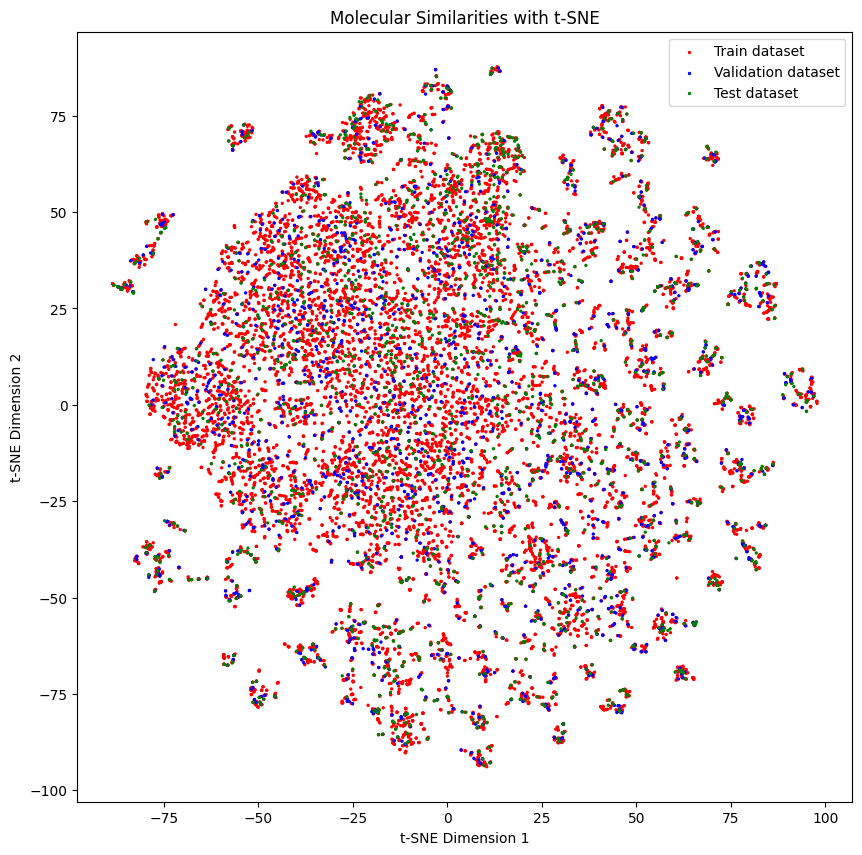

In [35]:
generate_tsne_molecular_similarities(train_dataset, valid_dataset, test_dataset)

In [36]:
MorganFingerprint().featurize(train_dataset, inplace=True)
MorganFingerprint().featurize(valid_dataset, inplace=True)
MorganFingerprint().featurize(test_dataset, inplace=True)

rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)
model.evaluate(test_dataset, [Metric(accuracy_score, name="accuracy")])

({'accuracy': 0.9617950272892662}, {})

As you see, the performance is a bit better than before.